# 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

# 2. Import Data

In [2]:
rawmta_df = pd.read_csv("./Turnstile_Usage_Data__2017.csv")
#mta_df = pd.read_csv("./Benson_Valentine.csv")
rawmta_df.columns = [column.strip() for column in rawmta_df.columns]
rawmta_df.head()

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/31/2016,03:00:00,REGULAR,5991546,2028378
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/31/2016,07:00:00,REGULAR,5991565,2028389
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/31/2016,11:00:00,REGULAR,5991644,2028441
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/31/2016,15:00:00,REGULAR,5991971,2028502
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/31/2016,19:00:00,REGULAR,5992418,2028543


# 3. Clean Data

## Convert to Datetime Object

In [3]:
rawmta_df['Datetime'] = pd.to_datetime(rawmta_df['Date'] + rawmta_df['Time'], 
                                       format='%m/%d/%Y%H:%M:%S')

## Select timeframe 

In [4]:
start_date1 = '20170101'
end_date1 = '20170203'
start_date2 = '20170212'
end_date2 = '20170227'
mta_df = rawmta_df[((rawmta_df['Datetime'] >= start_date1) & (rawmta_df['Datetime'] <= end_date1)) |
                   ((rawmta_df['Datetime'] >= start_date2) & (rawmta_df['Datetime'] <= end_date2))]

In [5]:
mta_df.head()

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits,Datetime
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2017,03:00:00,REGULAR,5992718,2028585,2017-01-01 03:00:00
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2017,07:00:00,REGULAR,5992730,2028594,2017-01-01 07:00:00
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2017,11:00:00,REGULAR,5992776,2028636,2017-01-01 11:00:00
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2017,15:00:00,REGULAR,5992980,2028680,2017-01-01 15:00:00
10,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2017,19:00:00,REGULAR,5993301,2028728,2017-01-01 19:00:00


## Filter REGULAR only

In [6]:
mta_reg_df = mta_df[mta_df['Description'] == 'REGULAR'].copy()
mta_reg_df = mta_reg_df.drop(['Description','Division', 'Exits'], axis=1)
mta_reg_df.head()

,C/A,Unit,SCP,Station,Line Name,Date,Time,Entries,Datetime
6,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,03:00:00,5992718,2017-01-01 03:00:00
7,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,07:00:00,5992730,2017-01-01 07:00:00
8,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,11:00:00,5992776,2017-01-01 11:00:00
9,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,15:00:00,5992980,2017-01-01 15:00:00
10,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,19:00:00,5993301,2017-01-01 19:00:00


## Sort dataframe and delete duplicates

In [7]:
mta_reg_df = mta_reg_df.sort_values(['C/A', 'Unit', 'SCP', 'Station', 'Line Name', 'Datetime'])
mta_reg_df = mta_reg_df.drop_duplicates(subset=['C/A', 'Unit', 'SCP', 'Station', 'Line Name', 'Datetime'])

## Add a column of day_of_week

In [8]:
#from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

#cal = calendar()
#holidays = cal.holidays(start=mta_df.Date.min(), end=mta_df.Date.max())

#mta_df['Holiday'] = mta_df['Date'].isin(holidays)

mta_reg_df['Day_of_Week'] = mta_reg_df['Datetime'].dt.dayofweek
#mta_df['Week_#'] = mta_df['Datetime'].dt.week

## Calculate Entries in Each Time Interval

In [9]:
mta_reg_df[['Previous_datetime', 'Previous_entries']] = (mta_reg_df
                                                     .groupby(['C/A', 'Unit', 'SCP', 'Station', 'Line Name'])["Datetime", "Entries"]
                                                     .transform(lambda grp: grp.shift(1))
                                                    )

## Clean abnormal net entry counts

In [10]:
# drop record with negative entries every 4 hours
# mta_df = mta_df[mta_df['Entries_4_hours_cleaned'] > 0]

def get_daily_counts(row, max_counter):
    counter = row["Entries"] - row["Previous_entries"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        counter = min(row["Entries"], row["Previous_entries"])
    if counter > max_counter:
        # Check it again to make sure we are not giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
mta_reg_df["Net_entries"] = mta_reg_df.apply(get_daily_counts, axis=1, max_counter=1000000)

In [11]:
mta_reg_df["Net_entries"] = mta_reg_df["Net_entries"].fillna(0)
mta_reg_df.loc[mta_reg_df['Datetime'] == '2017/2/12 00:00:00','Net_entries'] = 0
mta_reg_df = mta_reg_df.drop(['Entries'], axis=1)
mta_reg_df.head()

,C/A,Unit,SCP,Station,Line Name,Date,Time,Datetime,Day_of_Week,Previous_datetime,Previous_entries,Net_entries
6,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,03:00:00,2017-01-01 03:00:00,6,NaT,NaN,0.0
7,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,07:00:00,2017-01-01 07:00:00,6,2017-01-01 03:00:00,5992718.0,12.0
8,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,11:00:00,2017-01-01 11:00:00,6,2017-01-01 07:00:00,5992730.0,46.0
9,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,15:00:00,2017-01-01 15:00:00,6,2017-01-01 11:00:00,5992776.0,204.0
10,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,19:00:00,2017-01-01 19:00:00,6,2017-01-01 15:00:00,5992980.0,321.0


## Round the datatime to nearest hour for calculation convenience

In [12]:
mta_reg_df.Datetime.dt.minute.value_counts().head(10)

0     1233650
22      11725
30      10312
51       1767
19       1741
3        1720
5        1697
15       1685
7        1660
55       1643
Name: Datetime, dtype: int64

In [13]:
mta_reg_df['Datetime_cleaned'] = mta_reg_df.Datetime.dt.round('h')
mta_reg_df['Previous_datetime_cleaned'] = (mta_reg_df
                                           .groupby(['C/A', 'Unit', 'SCP', 'Station', 'Line Name'])["Datetime_cleaned"]
                                           .transform(lambda grp: grp.shift(1))
                                          )

In [14]:
mta_reg_df.head()

,C/A,Unit,SCP,Station,Line Name,Date,Time,Datetime,Day_of_Week,Previous_datetime,Previous_entries,Net_entries,Datetime_cleaned,Previous_datetime_cleaned
6,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,03:00:00,2017-01-01 03:00:00,6,NaT,NaN,0.0,2017-01-01 03:00:00,NaT
7,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,07:00:00,2017-01-01 07:00:00,6,2017-01-01 03:00:00,5992718.0,12.0,2017-01-01 07:00:00,2017-01-01 03:00:00
8,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,11:00:00,2017-01-01 11:00:00,6,2017-01-01 07:00:00,5992730.0,46.0,2017-01-01 11:00:00,2017-01-01 07:00:00
9,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,15:00:00,2017-01-01 15:00:00,6,2017-01-01 11:00:00,5992776.0,204.0,2017-01-01 15:00:00,2017-01-01 11:00:00
10,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,19:00:00,2017-01-01 19:00:00,6,2017-01-01 15:00:00,5992980.0,321.0,2017-01-01 19:00:00,2017-01-01 15:00:00


**After rounding the time, there are records with the same previous and current time. After checking the stats, most of these records have zero entries, so making a decision to drop those records**

In [15]:
(mta_reg_df[mta_reg_df['Datetime_cleaned'] == mta_reg_df['Previous_datetime_cleaned']]['Net_entries']
 .value_counts().head(10)
)

0.0     2569
1.0      835
2.0      458
3.0      319
4.0      243
5.0      172
6.0      134
7.0      105
8.0       93
11.0      75
Name: Net_entries, dtype: int64

In [16]:
mta_reg_df = mta_reg_df[mta_reg_df['Datetime_cleaned'] != mta_reg_df['Previous_datetime_cleaned']]

In [17]:
mta_reg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1329271 entries, 6 to 1562159
Data columns (total 14 columns):
C/A                          1329271 non-null object
Unit                         1329271 non-null object
SCP                          1329271 non-null object
Station                      1329271 non-null object
Line Name                    1329271 non-null object
Date                         1329271 non-null object
Time                         1329271 non-null object
Datetime                     1329271 non-null datetime64[ns]
Day_of_Week                  1329271 non-null int64
Previous_datetime            1324580 non-null datetime64[ns]
Previous_entries             1324580 non-null float64
Net_entries                  1329271 non-null float64
Datetime_cleaned             1329271 non-null datetime64[ns]
Previous_datetime_cleaned    1324580 non-null datetime64[ns]
dtypes: datetime64[ns](4), float64(2), int64(1), object(7)
memory usage: 152.1+ MB


**Create a new dataframe with cleaned datetime**

In [18]:
mta_reg_clean_time_df = mta_reg_df[['C/A', 'Unit', 'SCP', 'Station', 'Line Name', 'Date',
                                   'Day_of_Week', 'Datetime_cleaned','Previous_datetime_cleaned',
                                   'Net_entries']].copy()

**Calcuate time duration for the net entries**

In [19]:
mta_reg_clean_time_df['Time_difference'] = (mta_reg_clean_time_df['Datetime_cleaned'] 
                                            - mta_reg_clean_time_df['Previous_datetime_cleaned'])

**Reset Net_entries and Time_difference to zero for the first records on 2/12/207 due to the period skip**

In [20]:
mta_reg_clean_time_df.loc[(mta_reg_clean_time_df['Date']=='02/12/2017' )
                          & (mta_reg_clean_time_df['Time_difference'] >= pd.Timedelta('9 days')),
                         'Net_entries'] = 0

In [21]:
mta_reg_clean_time_df.loc[(mta_reg_clean_time_df['Date']=='02/12/2017' )
                          & (mta_reg_clean_time_df['Time_difference'] >= pd.Timedelta('9 days')),
                         'Time_difference'] = pd.Timedelta('0 hours')

**There are still 334 records of more than 1 day of entries getting summed to one record.**

**To drop or not to drop???**

In [22]:
mta_reg_clean_time_df[mta_reg_clean_time_df['Time_difference'] >= pd.Timedelta('1 days')].count()

C/A                          334
Unit                         334
SCP                          334
Station                      334
Line Name                    334
Date                         334
Day_of_Week                  334
Datetime_cleaned             334
Previous_datetime_cleaned    334
Net_entries                  334
Time_difference              334
dtype: int64

In [23]:
mta_reg_clean_time_df[mta_reg_clean_time_df['Time_difference'] < pd.Timedelta('1 days')].count()

C/A                          1324246
Unit                         1324246
SCP                          1324246
Station                      1324246
Line Name                    1324246
Date                         1324246
Day_of_Week                  1324246
Datetime_cleaned             1324246
Previous_datetime_cleaned    1324246
Net_entries                  1324246
Time_difference              1324246
dtype: int64

**Create new columns for average hourly net entries, calcuated from net entries and time difference.**

In [24]:
mta_reg_clean_time_df['Average_hourly_entries'] = (mta_reg_clean_time_df['Net_entries']
                                                   /(mta_reg_clean_time_df['Time_difference']/pd.Timedelta('1 hours'))
                                                  )


In [25]:
mta_reg_clean_time_df.head()

,C/A,Unit,SCP,Station,Line Name,Date,Day_of_Week,Datetime_cleaned,Previous_datetime_cleaned,Net_entries,Time_difference,Average_hourly_entries
6,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,6,2017-01-01 03:00:00,NaT,0.0,NaT,NaN
7,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,6,2017-01-01 07:00:00,2017-01-01 03:00:00,12.0,04:00:00,3.00
8,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,6,2017-01-01 11:00:00,2017-01-01 07:00:00,46.0,04:00:00,11.50
9,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,6,2017-01-01 15:00:00,2017-01-01 11:00:00,204.0,04:00:00,51.00
10,A002,R051,02-00-00,59 ST,NQR456W,01/01/2017,6,2017-01-01 19:00:00,2017-01-01 15:00:00,321.0,04:00:00,80.25


In [26]:
mta_final_df = mta_reg_clean_time_df[mta_reg_clean_time_df['Time_difference'] < pd.Timedelta('1 days')]

## 4. EDA

## Total number of turnstile

In [27]:
mta_final_df.groupby(['C/A','Unit', 'SCP', 'Station', 'Line Name'])['Net_entries'].sum().count()

4690

## total number of station

In [28]:
mta_final_df.groupby(['Station', 'Line Name'])['Net_entries'].sum().count()

476

## Statistic Summary of Cleaned Entries Every x Hours

In [29]:
# explore entries distribution
mta_final_df['Net_entries'].describe()

count    1.324246e+06
mean     1.827015e+02
std      2.484624e+03
min      0.000000e+00
25%      1.100000e+01
50%      7.300000e+01
75%      2.330000e+02
max      9.945160e+05
Name: Net_entries, dtype: float64

## distribution of entries in every x hours at a turnstile

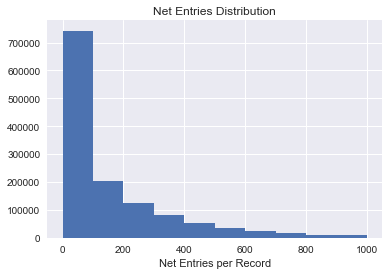

In [54]:
mta_final_df['Net_entries'].hist(range=[0, 1e3]);
plt.title('Net Entries Distribution');
plt.xlabel('Net Entries per Record');

## distribution of daily entries at a turnstile

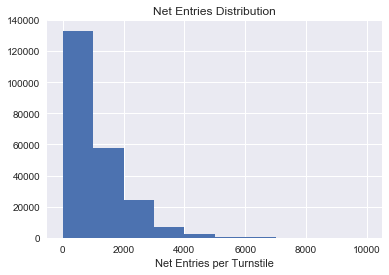

In [55]:
#mta_df.groupby(['C/A','Unit', 'SCP', 'Station', 'Date'])['Entries_4_hours_cleaned'].sum()
mta_final_df.groupby(['C/A','Unit', 'SCP', 'Station', 'Line Name','Date'])['Net_entries'].sum().hist(range=[0, 1e4]);
plt.title('Net Entries Distribution');
plt.xlabel('Net Entries per Turnstile');

## distribution of daily entries at a station

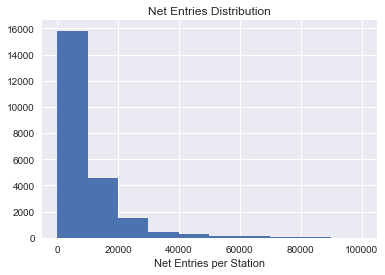

In [56]:
mta_final_df.groupby(['Station','Line Name', 'Date'])['Net_entries'].sum().hist(range=[0, 1e5]);
plt.title('Net Entries Distribution');
plt.xlabel('Net Entries per Station');

## distribution of sum of entries on a day of the week at a station

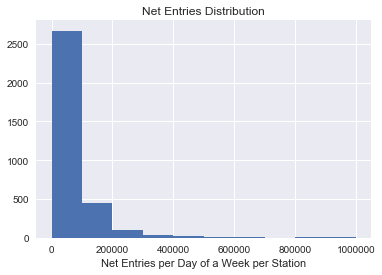

In [57]:
#mta_df.groupby(['Station', 'day'], as_index=False)['Entries_4_hours_cleaned'].sum()

mta_final_df.groupby(['Station', 'Line Name', 'Day_of_Week'])['Net_entries'].sum().hist(range=[0,1e6]);
plt.title('Net Entries Distribution');
plt.xlabel('Net Entries per Day of a Week per Station');

In [58]:
#mta_reg_df.groupby(['C/A', 'Unit', 'SCP', 'Station', 'Line Name', 'Date'], as_index=False)['counter_joe'].sum()

#mta_reg_clean_time_df['t_id'] = pd.factorize(mta_reg_clean_time_df['C/A']
#                                             +mta_reg_clean_time_df['Unit']
#                                             +mta_reg_clean_time_df['SCP']
#                                             +mta_reg_clean_time_df['Station']
#                                             +mta_reg_clean_time_df['Line Name'])[0]
#mta_reg_clean_time_df

In [59]:
total_entries = mta_final_df['Net_entries'].sum()
total_entries_df = mta_final_df.groupby(['Station', 'Line Name'], as_index=False)['Net_entries'].sum()
top20_station = (list(mta_final_df.groupby(['Station', 'Line Name'])['Net_entries']
                      .sum().sort_values(ascending=False).head(20).index)
                )
top20_station



[('GRD CNTRL-42 ST', '4567S'),
 ('34 ST-HERALD SQ', 'BDFMNQRW'),
 ('34 ST-PENN STA', 'ACE'),
 ('42 ST-PORT AUTH', 'ACENQRS1237W'),
 ('14 ST-UNION SQ', 'LNQR456W'),
 ('TIMES SQ-42 ST', '1237ACENQRSW'),
 ('FLUSHING-MAIN', '7'),
 ('JAMAICA CENTER', 'EJZ'),
 ('GROVE STREET', '1'),
 ('CHRISTOPHER ST', '1'),
 ('59 ST COLUMBUS', 'ABCD1'),
 ('FULTON ST', '2345ACJZ'),
 ('34 ST-PENN STA', '123ACE'),
 ('47-50 STS ROCK', 'BDFM'),
 ('CANAL ST', 'JNQRZ6W'),
 ('JKSN HT-ROOSVLT', 'EFMR7'),
 ('JOURNAL SQUARE', '1'),
 ('86 ST', '456'),
 ('W 4 ST-WASH SQ', 'ABCDEFM'),
 ('59 ST', '456NQRW')]

In [65]:
top_mant = top20_station[:6] + [top20_station[9]] + top20_station[10:14] + top20_station[14:15] + top20_station[17:] 
top_mant

[('GRD CNTRL-42 ST', '4567S'),
 ('34 ST-HERALD SQ', 'BDFMNQRW'),
 ('34 ST-PENN STA', 'ACE'),
 ('42 ST-PORT AUTH', 'ACENQRS1237W'),
 ('14 ST-UNION SQ', 'LNQR456W'),
 ('TIMES SQ-42 ST', '1237ACENQRSW'),
 ('CHRISTOPHER ST', '1'),
 ('59 ST COLUMBUS', 'ABCD1'),
 ('FULTON ST', '2345ACJZ'),
 ('34 ST-PENN STA', '123ACE'),
 ('47-50 STS ROCK', 'BDFM'),
 ('CANAL ST', 'JNQRZ6W'),
 ('86 ST', '456'),
 ('W 4 ST-WASH SQ', 'ABCDEFM'),
 ('59 ST', '456NQRW')]

In [64]:
top_non_mant = top20_station[6:9] + top20_station[15:17]
top_non_mant

[('FLUSHING-MAIN', '7'),
 ('JAMAICA CENTER', 'EJZ'),
 ('GROVE STREET', '1'),
 ('JKSN HT-ROOSVLT', 'EFMR7'),
 ('JOURNAL SQUARE', '1')]

In [36]:
total_entries_df = total_entries_df.rename(columns={'Net_entries': 'Total_entries'})

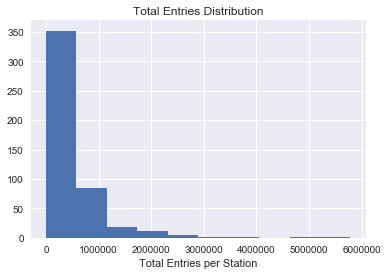

In [52]:
total_entries_df['Percentage'] = total_entries_df['Total_entries'] / (total_entries_df['Total_entries'].sum()) * 100

total_entries_df['Total_entries'].hist();

plt.title('Total Entries Distribution');
plt.xlabel('Total Entries per Station');

In [46]:
total_entries_df.Percentage.describe()

count    476.000000
mean       0.210084
std        0.246742
min        0.000000
25%        0.076276
50%        0.133128
75%        0.248187
max        2.392703
Name: Percentage, dtype: float64

In [48]:
total_entries_df.sort_values('Total_entries', ascending=False).head(50)

,Station,Line Name,Total_entries,Percentage
313,GRD CNTRL-42 ST,4567S,5788946.0,2.392703
90,34 ST-HERALD SQ,BDFMNQRW,5137852.0,2.123591
94,34 ST-PENN STA,ACE,3693565.0,1.526634
103,42 ST-PORT AUTH,ACENQRS1237W,3550983.0,1.467702
28,14 ST-UNION SQ,LNQR456W,3041252.0,1.257019
447,TIMES SQ-42 ST,1237ACENQRSW,2629966.0,1.087025
290,FLUSHING-MAIN,7,2390568.0,0.988076
334,JAMAICA CENTER,EJZ,2345590.0,0.969486
315,GROVE STREET,1,2345342.0,0.969383
248,CHRISTOPHER ST,1,2299147.0,0.950290


# 5. Visualization

In [39]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [40]:
graph = pd.read_csv('top20_station_with_coordinates.csv')

# Extract the data we're interested in
lat = graph['Station_latitude'].values
lon = graph['Station_longitude'].values
entries = graph['Percentage'].values * 200


/Users/yunshizhao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4771: RuntimeWarning: invalid value encountered in greater
  lonsin = np.where(lonsin > lon_0+180, lonsin-360 ,lonsin)
/Users/yunshizhao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4772: RuntimeWarning: invalid value encountered in less
  lonsin = np.where(lonsin < lon_0-180, lonsin+360 ,lonsin)
/Users/yunshizhao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4776: RuntimeWarning: invalid value encountered in greater_equal
  itemindex = len(lonsin)-np.where(londiff>=thresh)[0]
/Users/yunshizhao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yunshizhao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (

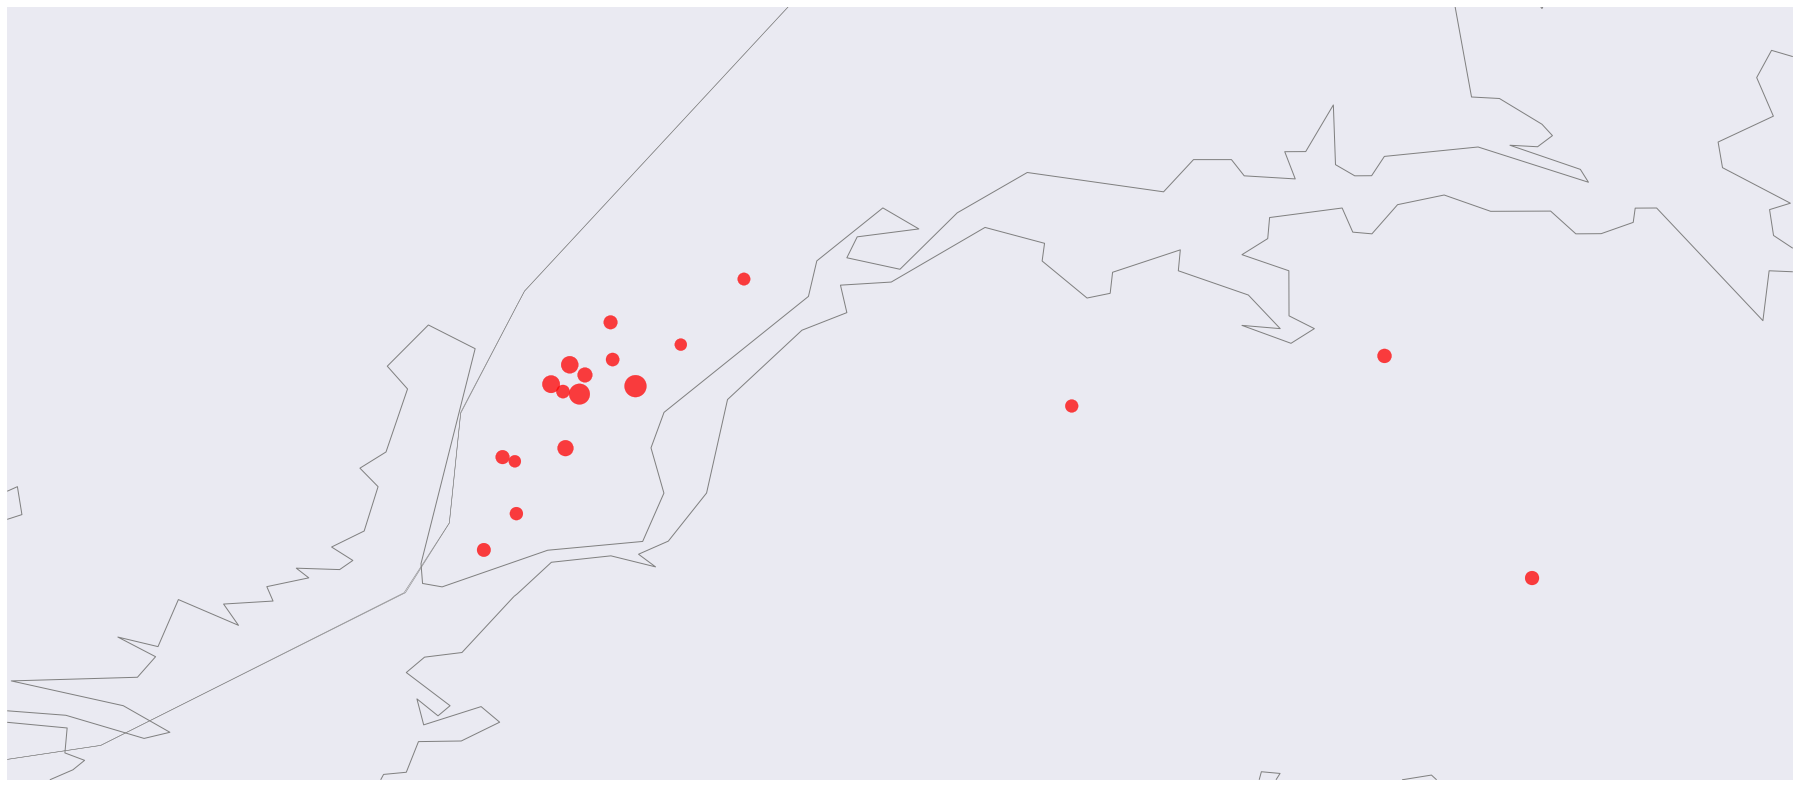

In [41]:
fig = plt.figure(figsize=(32, 32))

m = Basemap(projection='cea',llcrnrlat=40.65,urcrnrlat=40.85,
            llcrnrlon=-74.1,urcrnrlon=-73.75,resolution='h')
#m.fillcontinents(color='coral',lake_color='aqua')
#m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

m.scatter(lon, lat, latlon=True,
          s=entries,
          c='r', alpha=0.75)
plt.savefig('./map.png')
plt.show()